## **Importing packages and libraries**

In [7]:
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split


In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
import re
import nltk
import random
from nltk.corpus import stopwords

In [9]:
# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


## **Data Loading And exploration**

In [10]:
train_data = pd.read_csv('train.tsv', sep='\t', header=None)
dev_data = pd.read_csv('dev.tsv', sep='\t', header=None)
test_data = pd.read_csv('test.tsv', sep='\t', header=None)


train_data.columns = ['text', 'label']
dev_data.columns = ['text', 'label']
test_data.columns = ['text', 'label']

# Check if the data is loaded correctly now
print(train_data.head())


                                                text  label
0  a stirring , funny and finally transporting re...      1
1  apparently reassembled from the cutting room f...      0
2  they presume their audience wo n't sit still f...      0
3  this is a visually stunning rumination on love...      1
4  jonathan parker 's bartleby should have been t...      1


In [11]:
train_data.columns

Index(['text', 'label'], dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6920 entries, 0 to 6919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    6920 non-null   object
 1   label   6920 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 108.2+ KB
None
label
1    3610
0    3310
Name: count, dtype: int64


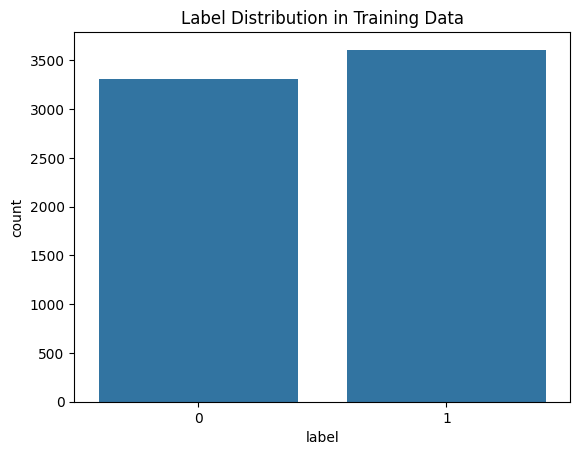

In [12]:
print(train_data.info())

print(train_data['label'].value_counts())


import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='label', data=train_data)
plt.title('Label Distribution in Training Data')
plt.show()


## **Data preprocessing**




*   **Text Preprocessing:**










### **Text Preprocessing:**
* *   Lowercasing
* *   Punctuation Removal
* *   Stopword Removal
* *   Lemmatization

In [13]:
#lowercasing and punctuation removal

def preprocess_text(text):

    text = text.lower()


    text = re.sub(r'[^\w\s]', '', text)

    return text


train_data['text'] = train_data['text'].apply(preprocess_text)
dev_data['text'] = dev_data['text'].apply(preprocess_text)
test_data['text'] = test_data['text'].apply(preprocess_text)


print(train_data.head())


                                                text  label
0  a stirring  funny and finally transporting re ...      1
1  apparently reassembled from the cutting room f...      0
2  they presume their audience wo nt sit still fo...      0
3  this is a visually stunning rumination on love...      1
4  jonathan parker s bartleby should have been th...      1


In [14]:
# Remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in stop_words])

# Apply stopword removal
train_data['text'] = train_data['text'].apply(remove_stopwords)
dev_data['text'] = dev_data['text'].apply(remove_stopwords)
test_data['text'] = test_data['text'].apply(remove_stopwords)

# Check the result
print(train_data.head())


                                                text  label
0  stirring funny finally transporting imagining ...      1
1  apparently reassembled cutting room floor give...      0
2  presume audience wo nt sit still sociology les...      0
3  visually stunning rumination love memory histo...      1
4  jonathan parker bartleby end modern office ano...      1


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
import nltk
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize the text
def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])

# Apply lemmatization to the text column
train_data['text'] = train_data['text'].apply(lemmatize_text)
dev_data['text'] = dev_data['text'].apply(lemmatize_text)
test_data['text'] = test_data['text'].apply(lemmatize_text)

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [16]:
X_train_dl=train_data['text']
X_valid_dl=dev_data['text']
X_test_dl=test_data['text']
y_train_dl=train_data['label']
y_valid_dl=dev_data['label']
y_test_dl=test_data['label']

## **Vectorization for classical machine learninr models**

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)  # You can adjust the number of features

# Fit and transform the text data
X_train = tfidf.fit_transform(train_data['text']).toarray()
X_valid = tfidf.transform(dev_data['text']).toarray()
X_test = tfidf.transform(test_data['text']).toarray()

# Get the labels (output variable)
y_train = train_data['label']
y_valid = dev_data['label']
y_test = test_data['label']

# Check the shape of the vectorized data
print(X_train.shape)


(6920, 5000)


## **Ml Models training and evaluation**

In [18]:

def train_and_evaluate_model(model, param_grid, X_train, y_train, X_valid, y_valid):
    start_time = time.time()  # Start timing

    # Perform Grid Search
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Record training time
    training_time = time.time() - start_time

    # Predict on validation set
    y_valid_pred = grid_search.predict(X_valid)
    valid_accuracy = accuracy_score(y_valid, y_valid_pred)

    # Predict on test set
    test_start_time = time.time()
    y_test_pred = grid_search.predict(X_test)
    test_end_time= time.time()
    pred_time = test_end_time - test_start_time
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Generate full classification report
    class_report = classification_report(y_valid, y_valid_pred)

    return {
        'best_params': grid_search.best_params_,
        'valid_accuracy': valid_accuracy,
        'test_accuracy': valid_accuracy,
        'training_time': training_time,
        'pred_time': pred_time,
        'classification_report': class_report,
        'best_model': grid_search.best_estimator_
    }

In [19]:
# Define parameter grids and models

param_grid_logreg = {'C': [0.01,0.001, 0.1, 1, 10,15], 'solver': ['liblinear', 'lbfgs']}
param_grid_nb = {'alpha': [0.01, 0.1, 1, 10]}
# param_grid_svm = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}

# Initialize models
logreg_model = LogisticRegression(max_iter=1000)
nb_model = MultinomialNB()
# svm_model = SVC()

In [20]:
# Logistic Regression
logreg_results = train_and_evaluate_model(logreg_model, param_grid_logreg, X_train, y_train, X_valid, y_valid)


In [21]:
logreg_results

{'best_params': {'C': 1, 'solver': 'lbfgs'},
 'valid_accuracy': 0.7729357798165137,
 'test_accuracy': 0.7729357798165137,
 'training_time': 49.18218016624451,
 'pred_time': 0.04763436317443848,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.78      0.75      0.76       428\n           1       0.77      0.80      0.78       444\n\n    accuracy                           0.77       872\n   macro avg       0.77      0.77      0.77       872\nweighted avg       0.77      0.77      0.77       872\n',
 'best_model': LogisticRegression(C=1, max_iter=1000)}

In [22]:
# Naive Bayes
nb_results = train_and_evaluate_model(nb_model, param_grid_nb, X_train, y_train, X_valid, y_valid)


In [23]:
nb_results

{'best_params': {'alpha': 1},
 'valid_accuracy': 0.7821100917431193,
 'test_accuracy': 0.7821100917431193,
 'training_time': 7.300421714782715,
 'pred_time': 0.030426979064941406,
 'classification_report': '              precision    recall  f1-score   support\n\n           0       0.80      0.74      0.77       428\n           1       0.77      0.82      0.79       444\n\n    accuracy                           0.78       872\n   macro avg       0.78      0.78      0.78       872\nweighted avg       0.78      0.78      0.78       872\n',
 'best_model': MultinomialNB(alpha=1)}


## **Tokenization for Bert**



In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the training, validation, and test data
def tokenize_data(texts, max_length=128):
    return tokenizer(
        texts.tolist(),
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='tf'
    )

# Assuming your datasets (X_train, X_valid, X_test) are pandas Series of text
train_encodings = tokenize_data(X_train_dl)
valid_encodings = tokenize_data(X_valid_dl)
test_encodings = tokenize_data(X_test_dl)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## **Bert model trainin and evaluation**

In [25]:
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
bert_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [27]:
# Convert labels to numpy array
y_train_dl = np.array(y_train_dl, dtype=int)
y_valid_dl = np.array(y_valid_dl, dtype=int)
y_test_dl = np.array(y_test_dl, dtype=int)


In [28]:
path_checkpoint="weights.keras"
checkpoint=tf.keras.callbacks.ModelCheckpoint(filepath=path_checkpoint,
                                              monitor='val_loss',
                                              verbose=1,
                                              save_best_only=True,
                                              save_weights_only=False,
                                              mode='auto',
                                              save_freq='epoch'
                                           #   period=1
                                              )

In [29]:

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    verbose=1,
    restore_best_weights=True
)


In [30]:
start_time = time.time()

bert_history = bert_model.fit(
    train_encodings['input_ids'], y_train_dl,
    validation_data=(valid_encodings['input_ids'], y_valid_dl),
    epochs=10,
    callbacks=[checkpoint, early_stopping],
    batch_size=32

)

training_time = time.time() - start_time
print(f"Training time: {training_time} seconds")

Epoch 1/10
217/217 [==============================] - ETA: 0s - loss: 0.5460 - accuracy: 0.6929
Epoch 1: val_loss improved from inf to 0.40901, saving model to weights.keras


/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


217/217 [==============================] - 280s 929ms/step - loss: 0.5460 - accuracy: 0.6929 - val_loss: 0.4090 - val_accuracy: 0.8119
Epoch 2/10
217/217 [==============================] - ETA: 0s - loss: 0.3237 - accuracy: 0.8669
Epoch 2: val_loss improved from 0.40901 to 0.36539, saving model to weights.keras
217/217 [==============================] - 266s 1s/step - loss: 0.3237 - accuracy: 0.8669 - val_loss: 0.3654 - val_accuracy: 0.8509
Epoch 3/10
217/217 [==============================] - ETA: 0s - loss: 0.1830 - accuracy: 0.9311
Epoch 3: val_loss did not improve from 0.36539
217/217 [==============================] - 190s 875ms/step - loss: 0.1830 - accuracy: 0.9311 - val_loss: 0.4808 - val_accuracy: 0.8245
Epoch 4/10
217/217 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9655
Epoch 4: val_loss did not improve from 0.36539
217/217 [==============================] - 189s 872ms/step - loss: 0.1035 - accuracy: 0.9655 - val_loss: 0.4935 - val_accuracy: 0.8372

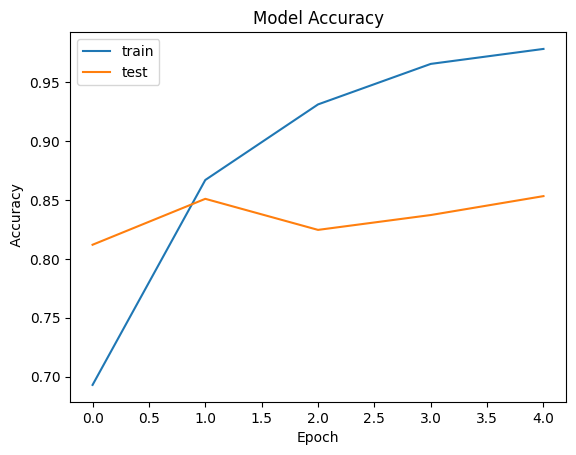

[0.8119266033172607, 0.8509174585342407, 0.8245412707328796, 0.8371559381484985, 0.853210985660553]
[0.6929190754890442, 0.86690753698349, 0.9310693740844727, 0.9654624462127686, 0.9781792163848877]


In [31]:
k='accuracy'


plt.plot(bert_history.history['accuracy'])
plt.plot(bert_history.history['val_'+k])
plt.title('Model Accuracy')
plt.ylabel(' Accuracy')
plt.xlabel('Epoch')
plt.legend(['train' , 'test'] , loc='upper left')
plt.show()

##print(history.history)

print(bert_history.history['val_'+k])
print(bert_history.history[k])

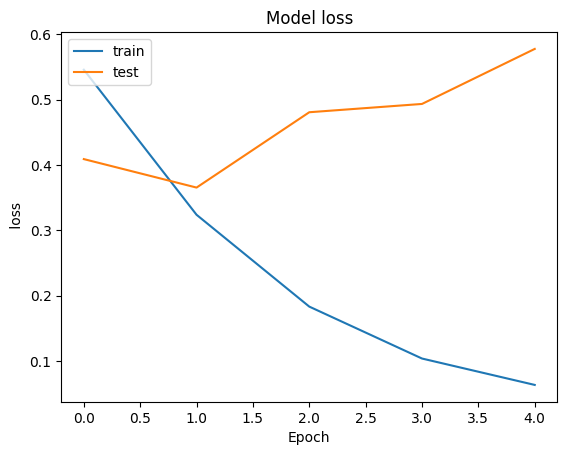

[0.545973539352417, 0.3237352669239044, 0.18302996456623077, 0.10347392410039902, 0.06304579973220825]


In [41]:
plt.plot(bert_history.history['loss'])
plt.plot(bert_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel(' loss')
plt.xlabel('Epoch')
plt.legend(['train' , 'test'] , loc='upper left')
plt.show()

print(bert_history.history['loss'])

In [42]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
# 2. Preprocess the test data

# Predict logits for the test set
y_test_logits = bert_model.predict(test_encodings)

# Convert logits to predicted class labels
y_test_pred = np.argmax(y_test_logits.logits, axis=1)
print(y_test_pred)
# Convert labels to numpy array
y_test_dl = np.array(y_test_dl, dtype=int)

test_accuracy = accuracy_score(y_test_dl, y_test_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Classification report for detailed metrics
print("Classification Report:\n", classification_report(y_test_dl, y_test_pred))


57/57 [==============================] - 17s 290ms/step
[0 0 0 ... 0 0 0]
Test Accuracy: 0.8484
Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.89      0.85       912
           1       0.88      0.81      0.84       909

    accuracy                           0.85      1821
   macro avg       0.85      0.85      0.85      1821
weighted avg       0.85      0.85      0.85      1821



## **Deployment** (flask api)


In [43]:
import joblib

# Save the trained model
joblib.dump(bert_model, 'sentiment_model.pkl')



/usr/local/lib/python3.10/dist-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


['sentiment_model.pkl']

In [44]:
bert_model.save_pretrained("model")
tokenizer.save_pretrained("model")

('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json')

In [45]:
model = TFBertForSequenceClassification.from_pretrained("model")
tokenizer = BertTokenizer.from_pretrained("model")


Some layers from the model checkpoint at model were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


In [46]:
from transformers import TFBertForSequenceClassification, BertTokenizer

model.save_pretrained("model")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
tokenizer.save_pretrained("model")


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


('model/tokenizer_config.json',
 'model/special_tokens_map.json',
 'model/vocab.txt',
 'model/added_tokens.json')

In [47]:
!pip install flask-ngrok
from flask_ngrok import run_with_ngrok

In [51]:
!pip install pyngrok
from pyngrok import ngrok

In [ ]:
from flask import Flask, request, jsonify
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

app = Flask(__name__)
run_with_ngrok(app)
model = TFBertForSequenceClassification.from_pretrained("model")
tokenizer = BertTokenizer.from_pretrained("model")

@app.route('/predict', methods=['POST'])
def predict():
    data = request.json
    texts = data['texts']


    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors='tf')


    predictions = model(encodings['input_ids'])[0]
    predicted_classes = tf.argmax(predictions, axis=1).numpy()

    return jsonify(predicted_classes.tolist())

if __name__ == '__main__':
    app.run()


Some layers from the model checkpoint at model were not used when initializing TFBertForSequenceClassification: ['dropout_151']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
Exception in thread Thread-13:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connection.py", line 199, in _new_conn
    sock = connection.create_connection(
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/usr/local/lib/python3.10/dist-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
  File "/usr/local/lib/python3.10/dist-packages/urll

In [53]:
!pip install pyngrok
from pyngrok import ngrok

# ... (rest of your code) ...

if __name__ == '__main__':
    # 1. Get your authtoken from https://dashboard.ngrok.com/get-started/your-authtoken
    # 2. Replace 'YOUR_AUTHTOKEN' with your actual authtoken
    ngrok.set_auth_token("YOUR_AUTHTOKEN")

    # Open an ngrok tunnel to the Flask app
    url = ngrok.connect(5000)
    print(f"ngrok tunnel available at: {url}")

    # Run the Flask app
    app.run()

ERROR:pyngrok.process.ngrok:t=2024-10-22T22:40:14+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok tunnel authtoken.\nYour authtoken: YOUR_AUTHTOKEN\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"
ERROR:pyngrok.process.ngrok:t=2024-10-22T22:40:14+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: The authtoken you specified does not look like a proper ngrok tunnel authtoken.\nYour authtoken: YOUR_AUTHTOKEN\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n"


PyngrokNgrokError: The ngrok process errored on start: authentication failed: The authtoken you specified does not look like a proper ngrok tunnel authtoken.\nYour authtoken: YOUR_AUTHTOKEN\nInstructions to install your authtoken are on your ngrok dashboard:\nhttps://dashboard.ngrok.com/get-started/your-authtoken\r\n\r\nERR_NGROK_105\r\n.

In [40]:
app.run(debug=True)

TypeError: run_with_ngrok.<locals>.new_run() got an unexpected keyword argument 'debug'

# **Optimizing to cure overfitting**
## **Data augmentation**